# GADMA with structure model (momentsLD)

For this example, we will run GADMA with the default structure demographic model and momentsLD engine. Structure defines how detailed the demographic model is and GADMA finds all possible parameters for this model. 

## Data

For this example, we will use a slightly modified simulation from the original moments.LD documentation. We will generate VCF file using demes for specifying the demographic model and msprime for simulation. GADMA automatically splits data into 15 equal regions.

### Data simulation

Python code for demes model generation

In [2]:
def demographic_model():
    b = demes.Builder()
    b.add_deme("anc", epochs=[dict(end_size=5000, end_time=2500)])
    b.add_deme("deme0", ancestors=["anc"], epochs=[dict(end_size=15000)])
    b.add_deme("deme1", ancestors=["anc"], epochs=[dict(end_size=10000)])
    b.add_migration(demes=["deme0", "deme1"], rate=1e-4)
    g = b.resolve()
    return g

Python code for msprime simulation

In [15]:
def run_msprime_replicates(num_reps=1, L=8000000, u=1.5e-8, r=1.5e-8, n=15):
    g = demographic_model()
    demog = msprime.Demography.from_demes(g)
    tree_sequences = msprime.sim_ancestry(
        {"deme0": n, "deme1": n},
        demography=demog,
        sequence_length=L,
        recombination_rate=r,
        num_replicates=num_reps,
        random_seed=42,
    )
    for ii, ts in enumerate(tree_sequences):
        ts = msprime.sim_mutations(ts, rate=u, random_seed=ii + 1)
        vcf_name = "./data/data_sim.vcf".format(ii)
        with open(vcf_name, "w+") as fout:
            ts.write_vcf(fout)

Python code for creation of recombination map and pop_map

In [5]:
def write_samples_and_rec_map(L=8000000, r=1.5e-8, n=15):
    # samples file
    with open("./data/pop_map.txt", "w+") as fout:
        fout.write("sample\tpop\n")
        for jj in range(2):
            for ii in range(n):
                fout.write(f"tsk_{jj * n + ii}\tdeme{jj}\n")
    # recombination map
    with open("./data/rec_map.txt", "w+") as fout:
        fout.write("pos\tMap(cM)\n")
        fout.write("0\t0\n")
        for ii in range(1, 15 + 1):
            fout.write(f"{round(L/15) * ii}\t{r * round(L/15) * 100 * ii}\n")

### Demographic model

Structure of the demographic model will be very simple, because we have a simple model.  We build the demographic model with one time interval for ancestral population before split and one time interval after split and symmetric migrations. So our ``Final structure`` should be (1, 1).

### Param files

In [4]:
%%bash
cat params_file

# Set data first
Input data : ./data_sim.vcf, ./pop_map.txt

# Set momentsLd engine for simulations
Engine : momentsLD

# Now set structures. We have simple structure without increase.
final_structure: 1,1

# Set directory with our recombination map
recombination_maps: ./rec_maps

# Set utput directory
Output directory : output

# momentsLD works only when ancestral_size_as_parameter. If you forget to set this parameter, GADMA will do it automatically
ancestral_size_as_parameter: True

# We could specify some additional properties of our model
# We want symmetric migrations and only sudden population size
Symmetric migrations: True
only_sudden: True
Mutation rate: 1.5e-8

# How many repeats to run and how many processes to use.
Number of repeats : 15
Number of processes : 6

# If we want to see a report on the calculation of LD statistics
ld_kwargs: {"report": True}


Now we could run GADMA

In [ ]:
%%bash
gadma -p params_file

GADMA will take some time for reading data and computing LD statistics. This time depends on the size of the data.

In [9]:
%%bash
# GADMA.log contains the same output we have during run. Let us see last lines again:
tail -n 20 gadma_result/GADMA.log

Run 15	-91163.86	[ [Nanc = 4918],	[ 1 pop split   13.49% (s1) [663.316(s1*Nanc), 4254.861((1-s1)*Nanc)] ],	[ 2197.72(t1), [36915.592(nu11), 16345.67(nu12)], [[0, 1.89e-09(m1_12)], [1.89e-09(m1_12), 0]], [Sud, Sud] ] ]	f	
Run 13	-91217.10	[ [Nanc = 5422],	[ 1 pop split   54.77% (s1) [2969.554(s1*Nanc), 2452.468((1-s1)*Nanc)] ],	[ 2247.009(t1), [35145.825(nu11), 17617.8(nu12)], [[0, 0.00e+00(m1_12)], [0.00e+00(m1_12), 0]], [Sud, Sud] ] ]	f	
Run 11	-91221.40	[ [Nanc = 5611],	[ 1 pop split   0.18% (s1) [9.884(s1*Nanc), 5601.611((1-s1)*Nanc)] ],	[ 2229.385(t1), [38206.28(nu11), 16633.709(nu12)], [[0, 0.00e+00(m1_12)], [0.00e+00(m1_12), 0]], [Sud, Sud] ] ]	f	
Run 9	-91230.50	[ [Nanc = 4836],	[ 1 pop split   12.90% (s1) [623.97(s1*Nanc), 4212.918((1-s1)*Nanc)] ],	[ 2227.273(t1), [37842.049(nu11), 16688.33(nu12)], [[0, 0.00e+00(m1_12)], [0.00e+00(m1_12), 0]], [Sud, Sud] ] ]	f	
Run 10	-91312.40	[ [Nanc = 4832],	[ 1 pop split   0.27% (s1) [13.14(s1*Nanc), 4819.321((1-s1)*Nanc)] ],	[ 2242.705(t1)

### Plots

File best_logLL_model.png have picture of our best model:

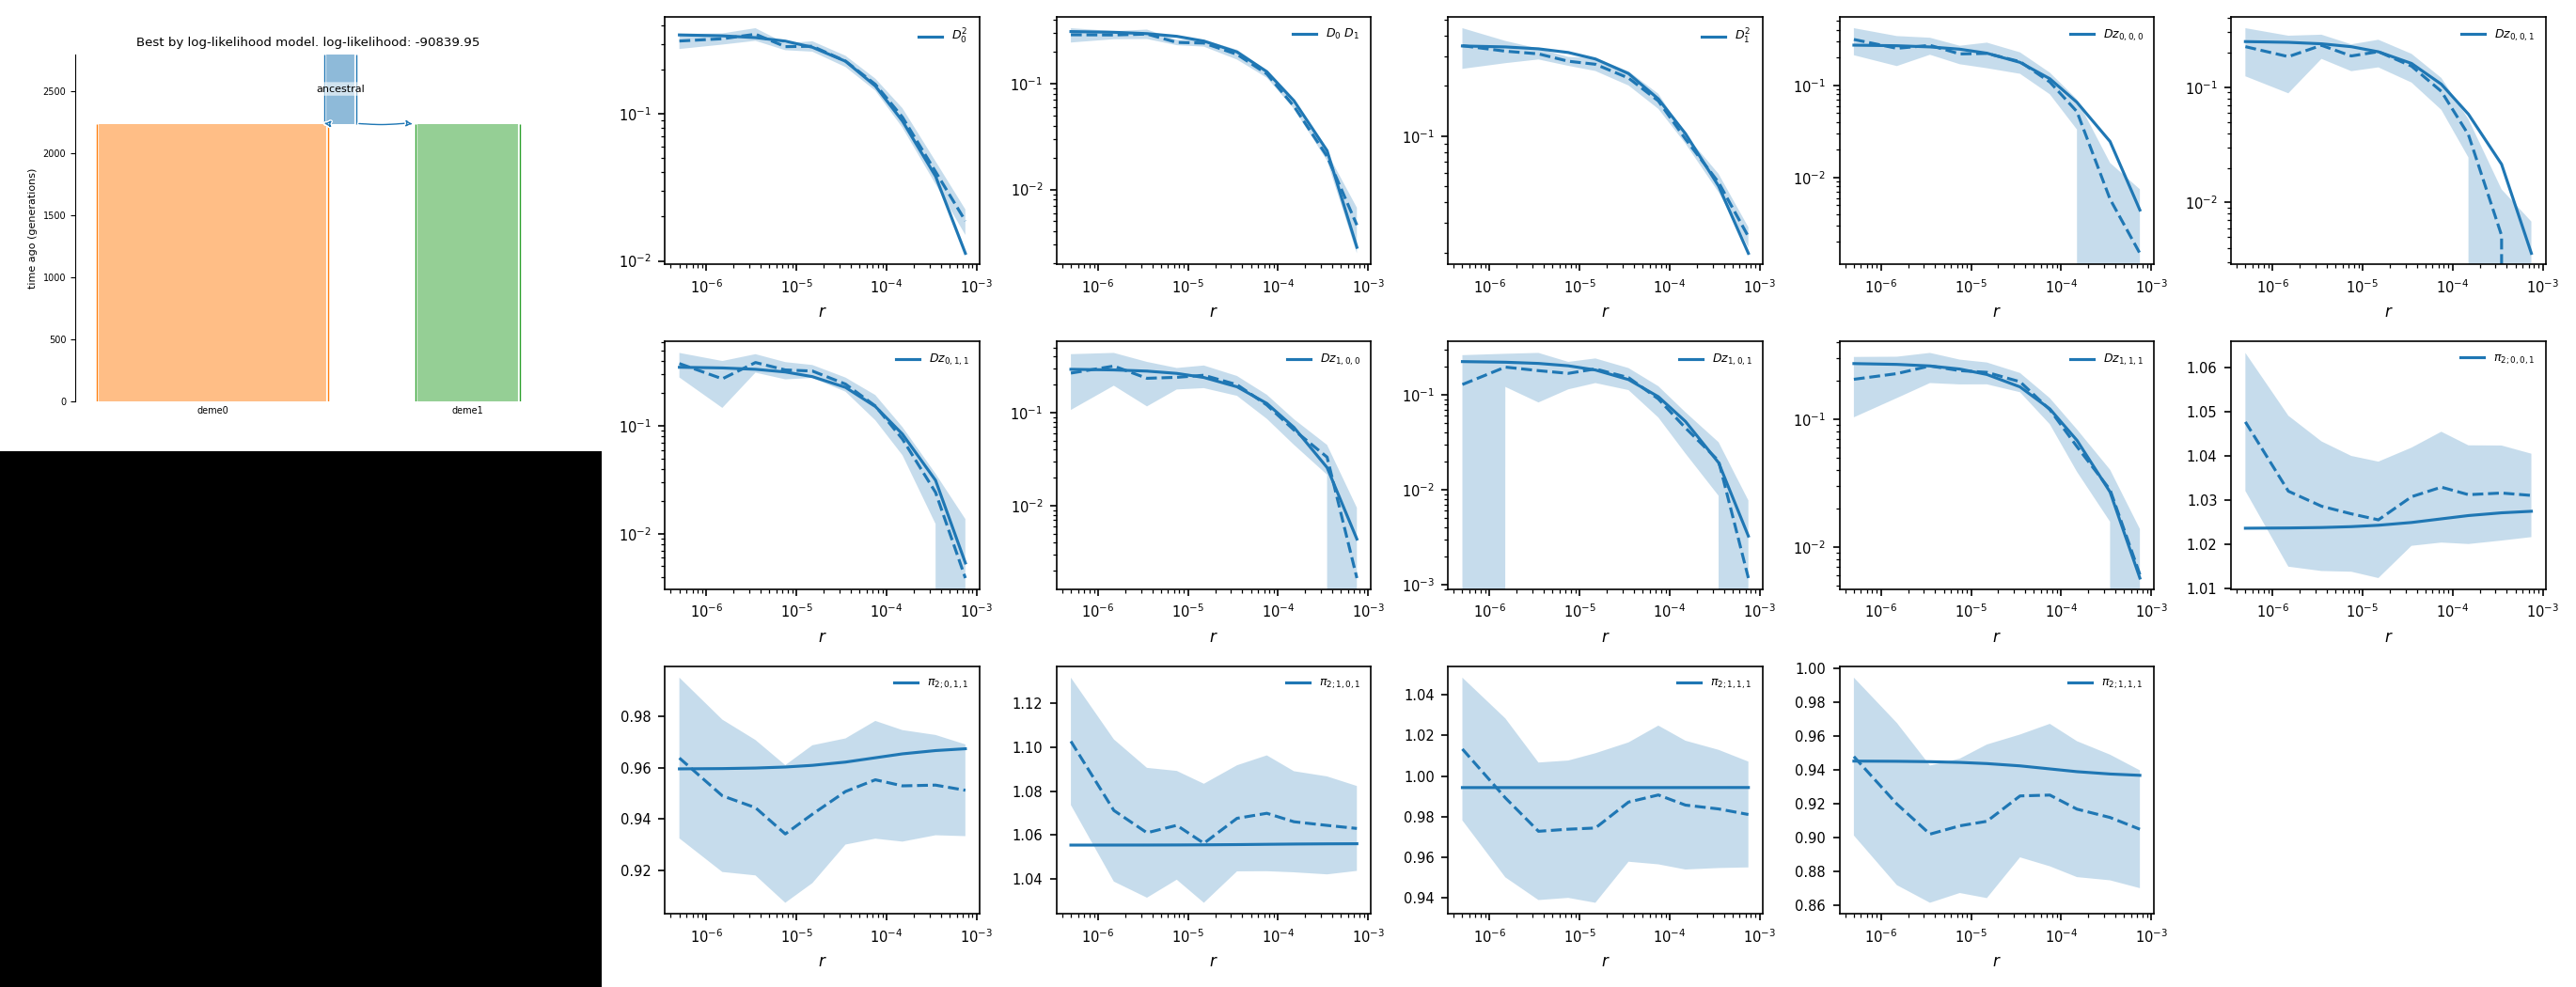

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 

Image("gadma_result/best_logLL_model.png")

### Generated code

In [13]:
%%bash
# Show generated code
cat gadma_result/best_logLL_model_momentsLD_code.py

import moments.LD
import numpy as np

def model_func(params):
	s1, t1, nu11, nu12, m1_12 = params
	Y = Numerics.steady_state(rho=rho, theta=theta)
	Y = LDstats(Y, num_pops=1, pop_ids=pop_ids))
	Y = Y.split(0)
	migs = np.array([[0, m1_12], [m1_12, 0]])
	Y.integrate(tf=t1, nu=[nu11,nu12], m=migs
	return Y

bed_files = /home/stas/git/gadma_moments/gadma_test_launch/8_sim_data_more_computing/output/bed_files/
reg_num = 0
region_stats = {}
chromosomes = {'1': 16}
extension = txt
rec_map = rec_map
kwargs = {
	r_bins: [0.e+00 1.e-06 2.e-06 5.e-06 1.e-05 2.e-05 5.e-05 1.e-04 2.e-04 5.e-04
 1.e-03],
	report: True,
	bp_bins: [      0 1655050 3310100 4965150 6620200],
	use_genotypes: True,
	cM: True,
}
vcf_file = /home/stas/git/gadma_moments/gadma_test_launch/8_sim_data_more_computing/data_sim.vcf
pop_map = /home/stas/git/gadma_moments/gadma_test_launch/8_sim_data_more_computing/pop_map.txt
rec_maps = /home/stas/git/gadma_moments/gadma_test_launch/8_sim_data_more_computing/rec_maps
for chrom in c